In [ ]:
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import json

from cassandra.query import SimpleStatement
import csv
import pandas as pd

from datetime import datetime
from cassandra.query import BatchStatement
from cassandra import ConsistencyLevel
import matplotlib.pyplot as plt

In [ ]:
# This secure connect bundle is autogenerated when you download your SCB,
# if yours is different update the file name below
cloud_config= {
  'secure_connect_bundle': './secure-connect-mydb.zip'
}

In [ ]:
# This token JSON file is autogenerated when you download your token,
# if yours is different update the file name below
with open("youfielwy@gmail.com-token.json") as f:
    secrets = json.load(f)

In [ ]:
CLIENT_ID = secrets["clientId"]
CLIENT_SECRET = secrets["secret"]

auth_provider = PlainTextAuthProvider(CLIENT_ID, CLIENT_SECRET)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

In [ ]:
# Printing the version
row = session.execute("select release_version from system.local").one()
if row:
  print(row[0])
else:
  print("An error occurred.")

4.0.0.6816


In [ ]:
# -✔️-- Describing a keyspace
session.set_keyspace('nyckeyspace') # replace <<KEYSPACENAME>> with the name of the keyspace you created in DataStax
row = cluster.metadata.keyspaces['nyckeyspace'] # replace <<KEYSPACENAME>> with the name of the keyspace you created in DataStax

from pprint import pprint
pprint(vars(row))

{'aggregates': {},
 'durable_writes': True,
 'functions': {},
 'graph_engine': None,
 'indexes': {},
 'name': 'nyckeyspace',
 'replication_strategy': <cassandra.metadata.NetworkTopologyStrategy object at 0x000001E0A5E24F10>,
 'tables': {'taxitrips': <cassandra.metadata.TableMetadataV3 object at 0x000001E0A5E25150>},
 'user_types': {'dropofflocation': <cassandra.metadata.UserType object at 0x000001E0A5E25AD0>,
                'pickuplocation': <cassandra.metadata.UserType object at 0x000001E0A5E25B50>},
 'views': {}}


In [ ]:
# DROPPING THE TABLE
session.execute("DROP TABLE IF EXISTS nyckeyspace.taxitrips;")

In [ ]:
# DROP THE UDTs
session.execute("DROP TYPE IF EXISTS nyckeyspace.pickuplocation;")
session.execute("DROP TYPE IF EXISTS nyckeyspace.dropofflocation;")

In [ ]:
# Read the csv file into a df
df1 = pd.read_csv('taxi_trip_data.csv', encoding='latin1')
print(df1.shape)

(10000000, 17)


In [ ]:
# Read the csv file into a df
df2 = pd.read_csv('taxi_zone_geo.csv', encoding='latin1')
print(df2.shape)

(263, 4)


In [ ]:
df1_sample = df1.sample(n=10000, random_state=42)
print(df1_sample.shape)

(10000, 17)


In [ ]:
df1_sample.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,pickup_location_id,dropoff_location_id
919213,1,2018-03-22 18:46:15,2018-03-22 19:06:55,1,1.50,1,N,1,13.5,1.0,0.5,1.25,0.0,0.3,16.55,161,143
9467153,2,2018-03-05 22:43:44,2018-03-05 22:55:38,1,6.07,1,N,1,18.5,0.5,0.5,3.00,0.0,0.3,22.80,231,141
6585777,1,2018-07-13 03:43:09,2018-07-13 03:55:38,1,3.50,1,N,1,13.0,0.5,0.5,5.00,0.0,0.3,19.30,233,145
3878022,2,2018-04-23 21:26:51,2018-04-23 21:41:40,2,2.41,1,N,1,11.5,0.5,0.5,2.56,0.0,0.3,15.36,170,158
5537116,2,2018-05-16 15:04:05,2018-05-16 15:27:43,6,4.99,1,N,1,18.5,0.0,0.5,1.00,0.0,0.3,20.30,239,244


In [ ]:
df2.head()

,zone_id,zone_name,borough,zone_geom
0,1,Newark Airport,EWR,"POLYGON((-74.1856319999999 40.6916479999999, -..."
1,3,Allerton/Pelham Gardens,Bronx,"POLYGON((-73.848596761 40.8716707849999, -73.8..."
2,18,Bedford Park,Bronx,"POLYGON((-73.8844286139999 40.8668003789999, -..."
3,20,Belmont,Bronx,"POLYGON((-73.8839239579998 40.8644177609999, -..."
4,31,Bronx Park,Bronx,"POLYGON((-73.8710017319999 40.8572767429999, -..."


### a) Remove the columns “store_and_fwd_flag”, “rate_code” and “total_amount” from taxitripdata

In [ ]:
df1_sample = df1_sample.drop(columns=['store_and_fwd_flag', 'rate_code', 'total_amount'])

In [ ]:
df1_sample.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,pickup_location_id,dropoff_location_id
919213,1,2018-03-22 18:46:15,2018-03-22 19:06:55,1,1.50,1,13.5,1.0,0.5,1.25,0.0,0.3,161,143
9467153,2,2018-03-05 22:43:44,2018-03-05 22:55:38,1,6.07,1,18.5,0.5,0.5,3.00,0.0,0.3,231,141
6585777,1,2018-07-13 03:43:09,2018-07-13 03:55:38,1,3.50,1,13.0,0.5,0.5,5.00,0.0,0.3,233,145
3878022,2,2018-04-23 21:26:51,2018-04-23 21:41:40,2,2.41,1,11.5,0.5,0.5,2.56,0.0,0.3,170,158
5537116,2,2018-05-16 15:04:05,2018-05-16 15:27:43,6,4.99,1,18.5,0.0,0.5,1.00,0.0,0.3,239,244


### b) Drop rows with missing essential details that would be required to fulfill the upcoming queries

In [ ]:
df1_sample.isnull().sum()

vendor_id              0
pickup_datetime        0
dropoff_datetime       0
passenger_count        0
trip_distance          0
payment_type           0
fare_amount            0
extra                  0
mta_tax                0
tip_amount             0
tolls_amount           0
imp_surcharge          0
pickup_location_id     0
dropoff_location_id    0
dtype: int64

In [ ]:
df2.isnull().sum()

zone_id      0
zone_name    0
borough      0
zone_geom    0
dtype: int64

##### Merging the two datasets

In [ ]:
df_merged = df1_sample.merge(df2[['zone_id', 'zone_name', 'borough', 'zone_geom']], left_on='pickup_location_id', right_on='zone_id', how='left')
df_merged = df_merged.rename(columns={'zone_name': 'pickup_zone_name', 'borough': 'pickup_borough', 'zone_geom': 'pickup_zone_geom'})

df_merged = df_merged.merge(df2[['zone_id', 'zone_name', 'borough', 'zone_geom']], left_on='dropoff_location_id', right_on='zone_id', how='left')
df_merged = df_merged.rename(columns={'zone_name': 'dropoff_zone_name', 'borough': 'dropoff_borough', 'zone_geom': 'dropoff_zone_geom'})

In [ ]:
df_merged.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount,extra,mta_tax,tip_amount,...,pickup_location_id,dropoff_location_id,zone_id_x,pickup_zone_name,pickup_borough,pickup_zone_geom,zone_id_y,dropoff_zone_name,dropoff_borough,dropoff_zone_geom
0,1,2018-03-22 18:46:15,2018-03-22 19:06:55,1,1.50,1,13.5,1.0,0.5,1.25,...,161,143,161.0,Midtown Center,Manhattan,"POLYGON((-73.9748872719999 40.7559237909999, -...",143.0,Lincoln Square West,Manhattan,"POLYGON((-73.9823261639999 40.7806237729999, -..."
1,2,2018-03-05 22:43:44,2018-03-05 22:55:38,1,6.07,1,18.5,0.5,0.5,3.00,...,231,141,231.0,TriBeCa/Civic Center,Manhattan,"POLYGON((-74.0100407869999 40.7252061629999, -...",141.0,Lenox Hill West,Manhattan,"POLYGON((-73.961767665 40.7598930409999, -73.9..."
2,1,2018-07-13 03:43:09,2018-07-13 03:55:38,1,3.50,1,13.0,0.5,0.5,5.00,...,233,145,233.0,UN/Turtle Bay South,Manhattan,MULTIPOLYGON(((-73.9642119246275 40.7466666768...,145.0,Long Island City/Hunters Point,Queens,"POLYGON((-73.944052652 40.7523132599999, -73.9..."
3,2,2018-04-23 21:26:51,2018-04-23 21:41:40,2,2.41,1,11.5,0.5,0.5,2.56,...,170,158,170.0,Murray Hill,Manhattan,"POLYGON((-73.971944289 40.7459318719999, -73.9...",158.0,Meatpacking/West Village West,Manhattan,"POLYGON((-74.0082040189999 40.7421475179999, -..."
4,2,2018-05-16 15:04:05,2018-05-16 15:27:43,6,4.99,1,18.5,0.0,0.5,1.00,...,239,244,239.0,Upper West Side South,Manhattan,"POLYGON((-73.9763914919999 40.7882667469999, -...",244.0,Washington Heights South,Manhattan,"POLYGON((-73.940889549 40.8513303679999, -73.9..."


In [ ]:
df2[df2['zone_id'] == 161]

,zone_id,zone_name,borough,zone_geom
214,161,Midtown Center,Manhattan,"POLYGON((-73.9748872719999 40.7559237909999, -..."


In [ ]:
df_merged = df_merged.drop(columns=['pickup_location_id', 'dropoff_location_id'])
df_merged = df_merged.rename(columns={'zone_id_x': 'pickup_zone_id', 'zone_id_y': 'dropoff_zone_id'})

In [ ]:
df_merged['id'] = df_merged.index

In [ ]:
df_merged.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount,extra,mta_tax,tip_amount,...,imp_surcharge,pickup_zone_id,pickup_zone_name,pickup_borough,pickup_zone_geom,dropoff_zone_id,dropoff_zone_name,dropoff_borough,dropoff_zone_geom,id
0,1,2018-03-22 18:46:15,2018-03-22 19:06:55,1,1.50,1,13.5,1.0,0.5,1.25,...,0.3,161.0,Midtown Center,Manhattan,"POLYGON((-73.9748872719999 40.7559237909999, -...",143.0,Lincoln Square West,Manhattan,"POLYGON((-73.9823261639999 40.7806237729999, -...",0
1,2,2018-03-05 22:43:44,2018-03-05 22:55:38,1,6.07,1,18.5,0.5,0.5,3.00,...,0.3,231.0,TriBeCa/Civic Center,Manhattan,"POLYGON((-74.0100407869999 40.7252061629999, -...",141.0,Lenox Hill West,Manhattan,"POLYGON((-73.961767665 40.7598930409999, -73.9...",1
2,1,2018-07-13 03:43:09,2018-07-13 03:55:38,1,3.50,1,13.0,0.5,0.5,5.00,...,0.3,233.0,UN/Turtle Bay South,Manhattan,MULTIPOLYGON(((-73.9642119246275 40.7466666768...,145.0,Long Island City/Hunters Point,Queens,"POLYGON((-73.944052652 40.7523132599999, -73.9...",2
3,2,2018-04-23 21:26:51,2018-04-23 21:41:40,2,2.41,1,11.5,0.5,0.5,2.56,...,0.3,170.0,Murray Hill,Manhattan,"POLYGON((-73.971944289 40.7459318719999, -73.9...",158.0,Meatpacking/West Village West,Manhattan,"POLYGON((-74.0082040189999 40.7421475179999, -...",3
4,2,2018-05-16 15:04:05,2018-05-16 15:27:43,6,4.99,1,18.5,0.0,0.5,1.00,...,0.3,239.0,Upper West Side South,Manhattan,"POLYGON((-73.9763914919999 40.7882667469999, -...",244.0,Washington Heights South,Manhattan,"POLYGON((-73.940889549 40.8513303679999, -73.9...",4


In [ ]:
df_merged.dtypes

vendor_id              int64
pickup_datetime       object
dropoff_datetime      object
passenger_count        int64
trip_distance        float64
payment_type           int64
fare_amount          float64
extra                float64
mta_tax              float64
tip_amount           float64
tolls_amount         float64
imp_surcharge        float64
pickup_zone_id       float64
pickup_zone_name      object
pickup_borough        object
pickup_zone_geom      object
dropoff_zone_id      float64
dropoff_zone_name     object
dropoff_borough       object
dropoff_zone_geom     object
id                     int64
dtype: object

In [ ]:
df_merged.isnull().sum()

vendor_id              0
pickup_datetime        0
dropoff_datetime       0
passenger_count        0
trip_distance          0
payment_type           0
fare_amount            0
extra                  0
mta_tax                0
tip_amount             0
tolls_amount           0
imp_surcharge          0
pickup_zone_id       176
pickup_zone_name     176
pickup_borough       176
pickup_zone_geom     176
dropoff_zone_id      173
dropoff_zone_name    173
dropoff_borough      173
dropoff_zone_geom    173
id                     0
dtype: int64

In [ ]:
# drop all rows with null values
df_merged = df_merged.dropna()

### c) Insert the data in the database as you see fit

In [ ]:
# Create two UDTs for the pickup and dropoff locations
# (pickup_zone_id	pickup_zone_name	pickup_borough	pickup_zone_geom)
# (dropoff_zone_id dropoff_zone_name dropoff_borough dropoff_zone_geom)

session.execute("create type if not exists pickuplocation ( pickup_zone_id int, pickup_zone_name text, pickup_borough text, pickup_zone_geom text );")
session.execute("create type if not exists dropofflocation ( dropoff_zone_id int, dropoff_zone_name text, dropoff_borough text, dropoff_zone_geom text );")

In [ ]:
session.execute("""
      create table if not exists nyckeyspace.taxitrips (
            id int,
            vendor_id int,
            pickup_datetime timestamp,
            dropoff_datetime timestamp,
            passenger_count int,
            trip_distance float,
            payment_type text,
            fare_amount float,
            extra float,
            mta_tax float,
            tip_amount float,
            tolls_amount float,
            imp_surcharge float,
            pickup_location pickuplocation,
            dropoff_location dropofflocation,

            Primary key (id)
      );
""")

In [ ]:
for index, row in df_merged.iterrows():
    print(row)
    break

vendor_id                                                            1
pickup_datetime                                    2018-03-22 18:46:15
dropoff_datetime                                   2018-03-22 19:06:55
passenger_count                                                      1
trip_distance                                                      1.5
payment_type                                                         1
fare_amount                                                       13.5
extra                                                              1.0
mta_tax                                                            0.5
tip_amount                                                        1.25
tolls_amount                                                       0.0
imp_surcharge                                                      0.3
pickup_zone_id                                                   161.0
pickup_zone_name                                        Midtown Center
pickup

In [ ]:
from datetime import datetime


for index, row in df_merged.iterrows():
    session.execute(
        """
        INSERT INTO nyckeyspace.taxitrips (
            id,
            vendor_id,
            pickup_datetime,
            dropoff_datetime,
            passenger_count,
            trip_distance,
            payment_type,
            fare_amount,
            extra,
            mta_tax,
            tip_amount,
            tolls_amount,
            imp_surcharge,
            pickup_location,
            dropoff_location
        ) VALUES (
            %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s,
            {pickup_zone_id: %s, pickup_zone_name: %s, pickup_borough: %s, pickup_zone_geom: %s},
            {dropoff_zone_id: %s, dropoff_zone_name: %s, dropoff_borough: %s, dropoff_zone_geom: %s}
        )
        """,
        (
            row['id'],
            row['vendor_id'],
            datetime.strptime(row['pickup_datetime'], '%Y-%m-%d %H:%M:%S'),
            datetime.strptime(row['dropoff_datetime'], '%Y-%m-%d %H:%M:%S'),
            row['passenger_count'],
            row['trip_distance'],
            str(row['payment_type']),
            row['fare_amount'],
            row['extra'],
            row['mta_tax'],
            row['tip_amount'],
            row['tolls_amount'],
            row['imp_surcharge'],
            int(row['pickup_zone_id']),
            row['pickup_zone_name'],
            row['pickup_borough'],
            row['pickup_zone_geom'],
            int(row['dropoff_zone_id']),
            row['dropoff_zone_name'],
            row['dropoff_borough'],
            row['dropoff_zone_geom']
        )
    )

In [ ]:
# get the number of rows in the cassandra table
rows = session.execute("SELECT COUNT(*) FROM nyckeyspace.taxitrips")
for row in rows:
    print(row)

Row(count=9800)


### d) Calculate the duration for each trip and add it as a new field in your database

In [ ]:
# Calculate duration for each trip and add it as a new column in the df_merged data frame
df_merged['pickup_datetime'] = pd.to_datetime(df_merged['pickup_datetime'])
df_merged['dropoff_datetime'] = pd.to_datetime(df_merged['dropoff_datetime'])
df_merged['fare_duration'] = (df_merged['dropoff_datetime'] - df_merged['pickup_datetime']).dt.total_seconds() / 60

In [ ]:
df_merged.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount,extra,mta_tax,tip_amount,...,pickup_zone_id,pickup_zone_name,pickup_borough,pickup_zone_geom,dropoff_zone_id,dropoff_zone_name,dropoff_borough,dropoff_zone_geom,id,fare_duration
0,1,2018-03-22 18:46:15,2018-03-22 19:06:55,1,1.50,1,13.5,1.0,0.5,1.25,...,161.0,Midtown Center,Manhattan,"POLYGON((-73.9748872719999 40.7559237909999, -...",143.0,Lincoln Square West,Manhattan,"POLYGON((-73.9823261639999 40.7806237729999, -...",0,20.666667
1,2,2018-03-05 22:43:44,2018-03-05 22:55:38,1,6.07,1,18.5,0.5,0.5,3.00,...,231.0,TriBeCa/Civic Center,Manhattan,"POLYGON((-74.0100407869999 40.7252061629999, -...",141.0,Lenox Hill West,Manhattan,"POLYGON((-73.961767665 40.7598930409999, -73.9...",1,11.900000
2,1,2018-07-13 03:43:09,2018-07-13 03:55:38,1,3.50,1,13.0,0.5,0.5,5.00,...,233.0,UN/Turtle Bay South,Manhattan,MULTIPOLYGON(((-73.9642119246275 40.7466666768...,145.0,Long Island City/Hunters Point,Queens,"POLYGON((-73.944052652 40.7523132599999, -73.9...",2,12.483333
3,2,2018-04-23 21:26:51,2018-04-23 21:41:40,2,2.41,1,11.5,0.5,0.5,2.56,...,170.0,Murray Hill,Manhattan,"POLYGON((-73.971944289 40.7459318719999, -73.9...",158.0,Meatpacking/West Village West,Manhattan,"POLYGON((-74.0082040189999 40.7421475179999, -...",3,14.816667
4,2,2018-05-16 15:04:05,2018-05-16 15:27:43,6,4.99,1,18.5,0.0,0.5,1.00,...,239.0,Upper West Side South,Manhattan,"POLYGON((-73.9763914919999 40.7882667469999, -...",244.0,Washington Heights South,Manhattan,"POLYGON((-73.940889549 40.8513303679999, -73.9...",4,23.633333


In [ ]:
# add the new column fare_duratiion to the cassandra table
session.execute("ALTER TABLE nyckeyspace.taxitrips ADD fare_duration float;")

for index, row in df_merged.iterrows():
    session.execute(
        """
        UPDATE nyckeyspace.taxitrips
        SET fare_duration = %s
        WHERE id = %s
        """,
        (row['fare_duration'], row['id'])
    )

In [ ]:
# print the first 5 rows of the cassandra table
rows = session.execute("SELECT * FROM nyckeyspace.taxitrips LIMIT 5")
for row in rows:
    print(row.id, row.pickup_datetime, row.dropoff_datetime, row.fare_duration)

4317 2018-11-30 13:42:41 2018-11-30 13:54:35 11.899999618530273
3372 2018-03-05 22:07:48 2018-03-05 22:19:34 11.766666412353516
1584 2018-02-18 12:02:25 2018-02-18 12:08:12 5.7833333015441895
7034 2018-10-01 20:25:32 2018-10-01 20:32:18 6.766666889190674
9892 2018-11-14 08:51:54 2018-11-14 09:06:15 14.350000381469727


### e) Use “fare_amount”, “extra”, “mta_tax”, “tip_amount”, “tolls_amount” and “imp_surcharge” to calculate the total trip cost and add it as a new field in your database

In [ ]:
df_merged['total_trip_cost'] = df_merged['fare_amount'] + df_merged['extra'] + df_merged['mta_tax'] + df_merged['tip_amount'] + df_merged['tolls_amount'] + df_merged['imp_surcharge']

In [ ]:
df_merged.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount,extra,mta_tax,tip_amount,...,pickup_zone_name,pickup_borough,pickup_zone_geom,dropoff_zone_id,dropoff_zone_name,dropoff_borough,dropoff_zone_geom,id,fare_duration,total_trip_cost
0,1,2018-03-22 18:46:15,2018-03-22 19:06:55,1,1.50,1,13.5,1.0,0.5,1.25,...,Midtown Center,Manhattan,"POLYGON((-73.9748872719999 40.7559237909999, -...",143.0,Lincoln Square West,Manhattan,"POLYGON((-73.9823261639999 40.7806237729999, -...",0,20.666667,16.55
1,2,2018-03-05 22:43:44,2018-03-05 22:55:38,1,6.07,1,18.5,0.5,0.5,3.00,...,TriBeCa/Civic Center,Manhattan,"POLYGON((-74.0100407869999 40.7252061629999, -...",141.0,Lenox Hill West,Manhattan,"POLYGON((-73.961767665 40.7598930409999, -73.9...",1,11.900000,22.80
2,1,2018-07-13 03:43:09,2018-07-13 03:55:38,1,3.50,1,13.0,0.5,0.5,5.00,...,UN/Turtle Bay South,Manhattan,MULTIPOLYGON(((-73.9642119246275 40.7466666768...,145.0,Long Island City/Hunters Point,Queens,"POLYGON((-73.944052652 40.7523132599999, -73.9...",2,12.483333,19.30
3,2,2018-04-23 21:26:51,2018-04-23 21:41:40,2,2.41,1,11.5,0.5,0.5,2.56,...,Murray Hill,Manhattan,"POLYGON((-73.971944289 40.7459318719999, -73.9...",158.0,Meatpacking/West Village West,Manhattan,"POLYGON((-74.0082040189999 40.7421475179999, -...",3,14.816667,15.36
4,2,2018-05-16 15:04:05,2018-05-16 15:27:43,6,4.99,1,18.5,0.0,0.5,1.00,...,Upper West Side South,Manhattan,"POLYGON((-73.9763914919999 40.7882667469999, -...",244.0,Washington Heights South,Manhattan,"POLYGON((-73.940889549 40.8513303679999, -73.9...",4,23.633333,20.30


In [ ]:
# add the new column total_trip_cost to the cassandra table if exists
session.execute("ALTER TABLE nyckeyspace.taxitrips ADD total_trip_cost float;")

for index, row in df_merged.iterrows():
    session.execute(
        """
        UPDATE nyckeyspace.taxitrips
        SET total_trip_cost = %s
        WHERE id = %s
        """,
        (row['total_trip_cost'], row['id'])
    )

In [ ]:
# print the first 5 rows of the cassandra table
rows = session.execute("SELECT * FROM nyckeyspace.taxitrips LIMIT 5")
for row in rows:
    print(row.id, row.total_trip_cost)

4317 9.300000190734863
3372 14.75
1584 9.800000190734863
7034 7.800000190734863
9892 12.359999656677246


### f) What is the most common payment type used per time of day?

### Hint: time of day meaning morning, afternoon or evening

In [ ]:
# Define a method that will return the time range of a given time
# Time ranges: [Morning, Afternoon, Evening]

def get_time_range(time):
    hour = time.hour
    if hour < 12:
        return "morning"
    elif hour < 18:
        return "afternoon"
    else:
        return "evening"

# Create the column in the dataframe
df_merged['time_range'] = df_merged['dropoff_datetime'].apply(get_time_range)

In [ ]:
df_merged.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount,extra,mta_tax,tip_amount,...,pickup_borough,pickup_zone_geom,dropoff_zone_id,dropoff_zone_name,dropoff_borough,dropoff_zone_geom,id,fare_duration,total_trip_cost,time_range
0,1,2018-03-22 18:46:15,2018-03-22 19:06:55,1,1.50,1,13.5,1.0,0.5,1.25,...,Manhattan,"POLYGON((-73.9748872719999 40.7559237909999, -...",143.0,Lincoln Square West,Manhattan,"POLYGON((-73.9823261639999 40.7806237729999, -...",0,20.666667,16.55,evening
1,2,2018-03-05 22:43:44,2018-03-05 22:55:38,1,6.07,1,18.5,0.5,0.5,3.00,...,Manhattan,"POLYGON((-74.0100407869999 40.7252061629999, -...",141.0,Lenox Hill West,Manhattan,"POLYGON((-73.961767665 40.7598930409999, -73.9...",1,11.900000,22.80,evening
2,1,2018-07-13 03:43:09,2018-07-13 03:55:38,1,3.50,1,13.0,0.5,0.5,5.00,...,Manhattan,MULTIPOLYGON(((-73.9642119246275 40.7466666768...,145.0,Long Island City/Hunters Point,Queens,"POLYGON((-73.944052652 40.7523132599999, -73.9...",2,12.483333,19.30,morning
3,2,2018-04-23 21:26:51,2018-04-23 21:41:40,2,2.41,1,11.5,0.5,0.5,2.56,...,Manhattan,"POLYGON((-73.971944289 40.7459318719999, -73.9...",158.0,Meatpacking/West Village West,Manhattan,"POLYGON((-74.0082040189999 40.7421475179999, -...",3,14.816667,15.36,evening
4,2,2018-05-16 15:04:05,2018-05-16 15:27:43,6,4.99,1,18.5,0.0,0.5,1.00,...,Manhattan,"POLYGON((-73.9763914919999 40.7882667469999, -...",244.0,Washington Heights South,Manhattan,"POLYGON((-73.940889549 40.8513303679999, -73.9...",4,23.633333,20.30,afternoon


In [ ]:
# add the new column fare_duratiion to the cassandra table
session.execute("ALTER TABLE nyckeyspace.taxitrips ADD time_range2 text;")

for index, row in df_merged.iterrows():
    session.execute(
        """
        UPDATE nyckeyspace.taxitrips
        SET time_range2 = %s
        WHERE id = %s
        """,
        (row['time_range'], row['id'])
    )

In [ ]:
# print the first 5 rows of the cassandra table
rows = session.execute("SELECT * FROM nyckeyspace.taxitrips LIMIT 5")
for row in rows:
    print(row.id, row.time_range2)

4317 afternoon
3372 evening
1584 afternoon
7034 evening
9892 morning


In [ ]:
# 1. Group the dataframe by time_range.
# 2. For each group, find the most common payment type.
      # ['payment_type']: This specifies the column on which the operation (getting the most common payment type / mode of payment type) will be performed
      # transform: This specifies the custom operation to be performed on each group.
      # The operation itself is getting the payment_type mode.
      # the mode returns an array, so [0] returns the first one (the most frequent payment_type)
      # x is simply an group instance. (a set of rows with the same time range)

most_common_payment_type_per_time = df_merged.groupby('time_range')['payment_type'].apply(lambda x: x.mode()[0])
most_common_payment_type_per_time

time_range
afternoon    1
evening      1
morning      1
Name: payment_type, dtype: int64

In [ ]:
# Read the time_range and the payment_type from the cassandra table
rows = session.execute("SELECT time_range2, payment_type FROM nyckeyspace.taxitrips")

# Save the result in a list to create a dataframe with later on.
result = []
for row in rows:
    result.append({row.time_range2: row.payment_type})

print(result)

[{'afternoon': '2'}, {'evening': '1'}, {'afternoon': '1'}, {'evening': '2'}, {'morning': '1'}, {'morning': '1'}, {'morning': '2'}, {'evening': '1'}, {'afternoon': '1'}, {'afternoon': '1'}, {'morning': '2'}, {'morning': '1'}, {'afternoon': '1'}, {'afternoon': '2'}, {'afternoon': '1'}, {'morning': '1'}, {'afternoon': '2'}, {'evening': '1'}, {'evening': '2'}, {'evening': '1'}, {'evening': '1'}, {'morning': '1'}, {'morning': '2'}, {'morning': '2'}, {'morning': '2'}, {'evening': '1'}, {'afternoon': '1'}, {'afternoon': '2'}, {'evening': '1'}, {'morning': '2'}, {'morning': '1'}, {'afternoon': '2'}, {'evening': '2'}, {'afternoon': '2'}, {'evening': '1'}, {'evening': '1'}, {'evening': '1'}, {'evening': '1'}, {'morning': '1'}, {'morning': '1'}, {'afternoon': '1'}, {'morning': '2'}, {'afternoon': '2'}, {'evening': '1'}, {'morning': '1'}, {'evening': '2'}, {'morning': '1'}, {'evening': '2'}, {'evening': '1'}, {'evening': '1'}, {'evening': '1'}, {'morning': '1'}, {'afternoon': '1'}, {'evening': '1'

In [ ]:
# create a df our of rows.time_range2 and rows.payment_type
payment_type_counts_per_time_df = pd.DataFrame(result)
payment_type_counts_per_time_df

,afternoon,evening,morning
0,2,NaN,NaN
1,NaN,1,NaN
2,1,NaN,NaN
3,NaN,2,NaN
4,NaN,NaN,1
...,...,...,...
9795,NaN,NaN,1
9796,1,NaN,NaN
9797,2,NaN,NaN
9798,NaN,NaN,1


In [ ]:
# group the counts of each payment_type per time_range in a new df from the payment_type_counts_per_time_df.
# pd.Series.value_counts calculates the frequency of unique values in a Series
payment_type_counts_per_time_df = payment_type_counts_per_time_df.apply(pd.Series.value_counts)
payment_type_counts_per_time_df

,afternoon,evening,morning
1,2088,2362,2414
2,993,882,1000
3,10,11,22
4,3,7,8


In [ ]:
# now show the most frequent payment type per time range
payment_type_counts_per_time_df.idxmax(axis=0)

afternoon    1
evening      1
morning      1
dtype: object

In [ ]:
# Get the transpose of the dataframe.
# This simply flips the index with the columns
payment_type_counts_per_time_df_transposed = payment_type_counts_per_time_df.T
payment_type_counts_per_time_df_transposed

,1,2,3,4
afternoon,2088,993,10,3
evening,2362,882,11,7
morning,2414,1000,22,8


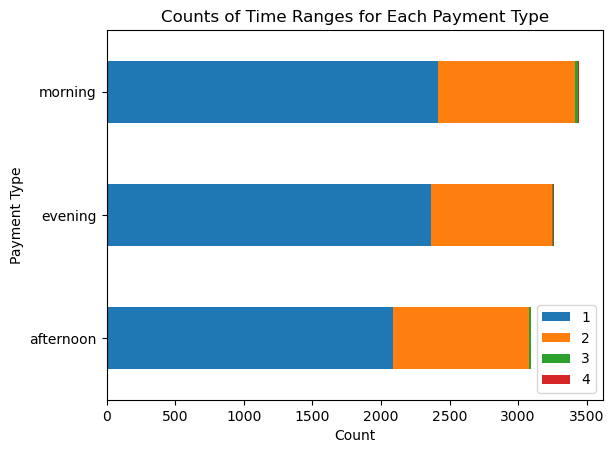

In [ ]:
# Create a bar plot of the payment type counts per time range.
payment_type_counts_per_time_df_transposed.plot(kind='barh', stacked=True)

plt.ylabel('Payment Type')
plt.xlabel('Count')
plt.title('Counts of Time Ranges for Each Payment Type')
plt.show()

 ### g) What is the average tip amount per passenger count?

In [ ]:
# Get all the unique passenger counts
unique_passenger_counts = df_merged['passenger_count'].unique()
print(unique_passenger_counts)

[1 2 6 5 4 3 0]


In [ ]:
# Get the average tip amount for each passenger count.
average_tip_amount = df_merged.groupby('passenger_count')['tip_amount'].mean()
print(average_tip_amount)

passenger_count
0    1.699091
1    1.865380
2    1.966586
3    1.627738
4    1.405722
5    1.851039
6    1.837345
Name: tip_amount, dtype: float64


In [ ]:
# Execute a query to get the average tip amount per passenger count.
rows = session.execute("SELECT passenger_count, tip_amount AS average_tip_amount FROM nyckeyspace.taxitrips")

# Save the result in a list, to be able to create a dataframe out if it later.
result = []
for row in rows:
    result.append({row.passenger_count: row.average_tip_amount})

print(result)

[{1: 0.0}, {1: 2.450000047683716}, {1: 2.0}, {1: 0.0}, {1: 2.059999942779541}, {2: 2.319999933242798}, {1: 0.0}, {1: 2.049999952316284}, {1: 3.4700000286102295}, {1: 1.8600000143051147}, {1: 0.0}, {1: 2.6600000858306885}, {1: 1.9500000476837158}, {1: 0.0}, {1: 1.7999999523162842}, {1: 3.049999952316284}, {2: 0.0}, {6: 1.2599999904632568}, {3: 0.0}, {1: 2.0}, {1: 1.159999966621399}, {3: 1.2599999904632568}, {1: 0.0}, {2: 0.0}, {4: 0.0}, {3: 1.159999966621399}, {1: 0.5299999713897705}, {1: 0.0}, {1: 2.450000047683716}, {1: 0.0}, {2: 1.8899999856948853}, {1: 0.0}, {2: 0.0}, {1: 0.0}, {1: 4.550000190734863}, {1: 1.25}, {1: 1.8600000143051147}, {1: 1.0}, {3: 0.0}, {1: 2.200000047683716}, {1: 3.049999952316284}, {1: 0.0}, {1: 0.0}, {2: 0.0}, {4: 1.7000000476837158}, {2: 0.0}, {1: 2.950000047683716}, {1: 0.0}, {3: 2.1600000858306885}, {1: 3.5299999713897705}, {1: 2.450000047683716}, {1: 9.0}, {2: 3.9000000953674316}, {1: 2.859999895095825}, {1: 0.019999999552965164}, {1: 0.0}, {1: 1.580000042

In [ ]:
# create a df out of rows.passenger_count and rows.average_tip_amount
average_tip_amount_per_passenger_count_df = pd.DataFrame(result)
average_tip_amount_per_passenger_count_df

,1,2,6,3,4,5,0
0,0.00,NaN,NaN,NaN,NaN,NaN,NaN
1,2.45,NaN,NaN,NaN,NaN,NaN,NaN
2,2.00,NaN,NaN,NaN,NaN,NaN,NaN
3,0.00,NaN,NaN,NaN,NaN,NaN,NaN
4,2.06,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
9795,1.00,NaN,NaN,NaN,NaN,NaN,NaN
9796,NaN,NaN,1.25,NaN,NaN,NaN,NaN
9797,0.00,NaN,NaN,NaN,NaN,NaN,NaN
9798,2.66,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# each column is a different passenger_count numner.
# So we get the average value in each column, and save it in a new df.
average_tip_amount_per_passenger_count_df = average_tip_amount_per_passenger_count_df.mean()
average_tip_amount_per_passenger_count_df

1    1.865380
2    1.966586
6    1.837345
3    1.627738
4    1.405722
5    1.851039
0    1.699091
dtype: float64

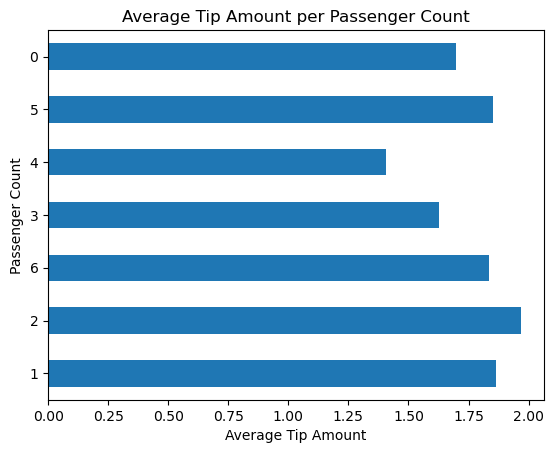

In [ ]:
# Create a bar plot of the average tip amount per passenger count.
average_tip_amount_per_passenger_count_df.plot(kind='barh', x='passenger_count', y='average_tip_amount')

plt.ylabel('Passenger Count')
plt.xlabel('Average Tip Amount')
plt.title('Average Tip Amount per Passenger Count')
plt.show()


### h) What are the best 5 locations for drivers to pick up passengers from?

In [ ]:
# Group by pickup_zone_name and count the occurrences.
# Then get the top 5 pickup locations.
best_pickup_locations = df_merged['pickup_zone_name'].value_counts().nlargest(5)
print(best_pickup_locations)

pickup_zone_name
Upper East Side North        386
Times Sq/Theatre District    362
Midtown Center               359
Upper East Side South        354
Murray Hill                  341
Name: count, dtype: int64


In [ ]:
# Get the top 5 pickup locations from the cassandra table.
rows = session.execute("SELECT pickup_location.pickup_zone_name FROM nyckeyspace.taxitrips")

# Save the result in a list, to be able to create a dataframe out if it later.
result = []
for row in rows:
    result.append(row.pickup_location_pickup_zone_name)

print(result)

['Lower East Side', 'World Trade Center', 'Upper East Side North', 'East Chelsea', 'Flatiron', 'Times Sq/Theatre District', 'Gramercy', 'Lincoln Square West', 'Union Sq', 'Penn Station/Madison Sq West', 'Lincoln Square East', 'Seaport', 'Yorkville West', 'Central Harlem North', 'Gramercy', 'Greenwich Village South', 'JFK Airport', 'West Village', 'West Village', 'Garment District', 'Yorkville West', 'Times Sq/Theatre District', 'Midtown East', 'Lincoln Square East', 'Greenwich Village North', 'Yorkville West', 'Upper East Side North', 'Upper East Side North', 'Midtown Center', 'Clinton East', 'Midtown East', 'Times Sq/Theatre District', 'Midtown North', 'East Chelsea', 'East Chelsea', 'Hudson Sq', 'Lower East Side', 'SoHo', 'West Village', 'Kips Bay', 'Lincoln Square West', 'Garment District', 'East Chelsea', 'Garment District', 'West Chelsea/Hudson Yards', 'Lincoln Square West', 'Lincoln Square East', 'Union Sq', 'Gramercy', 'TriBeCa/Civic Center', 'Penn Station/Madison Sq West', 'LaG

In [ ]:
# create a df out of result
best_pickup_locations_df = pd.DataFrame(result)
best_pickup_locations_df

,0
0,Lower East Side
1,World Trade Center
2,Upper East Side North
3,East Chelsea
4,Flatiron
...,...
9795,East Village
9796,Sutton Place/Turtle Bay North
9797,Midtown East
9798,Midtown Center


In [ ]:
# count the number of occurences of each pick_up_zone name.
best_pickup_locations_df = best_pickup_locations_df.apply(pd.Series.value_counts)

# get the top 5 pickup locations
best_pickup_locations_df = best_pickup_locations_df.nlargest(5, columns=0)

# change the column name to count
best_pickup_locations_df.columns = ['count']
best_pickup_locations_df

,count
0,
Upper East Side North,386
Times Sq/Theatre District,362
Midtown Center,359
Upper East Side South,354
Murray Hill,341


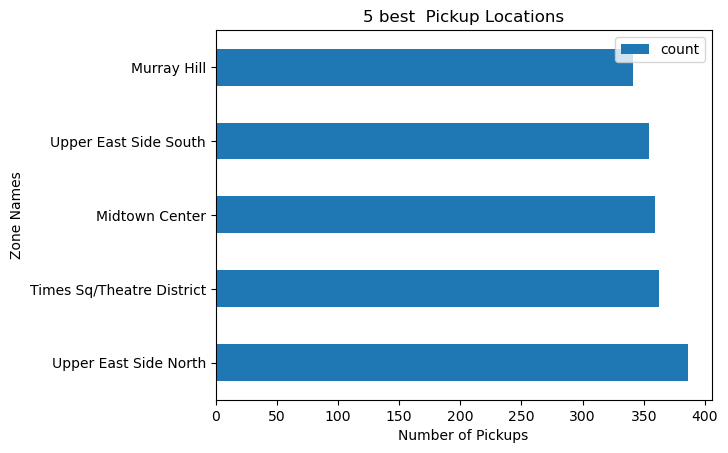

In [ ]:
# Create a barchart of the top 5 pickup locations.
best_pickup_locations_df.plot(kind='barh')

plt.xlabel('Number of Pickups')
plt.ylabel('Zone Names')
plt.title('5 best  Pickup Locations')
plt.show()


## Bonus

Is there a correlation between trip distance and the tip amount? (not to be done using the correlation calculation)

In [ ]:
# read the trip_distance and tip_amount columns from the cassandra table and save them in a df
rows = session.execute("SELECT trip_distance, tip_amount FROM nyckeyspace.taxitrips")

# read the row.trip_distance: row.tip_amount and save it in a df
result = []
for row in rows:
    result.append([row.trip_distance, row.tip_amount])

# create a df out of result
trip_distance_tip_amount_df = pd.DataFrame(result, columns=['trip_distance', 'tip_amount'])
trip_distance_tip_amount_df.head()

,trip_distance,tip_amount
0,1.00,0.00
1,2.70,2.45
2,1.60,2.00
3,1.25,0.00
4,0.80,2.06


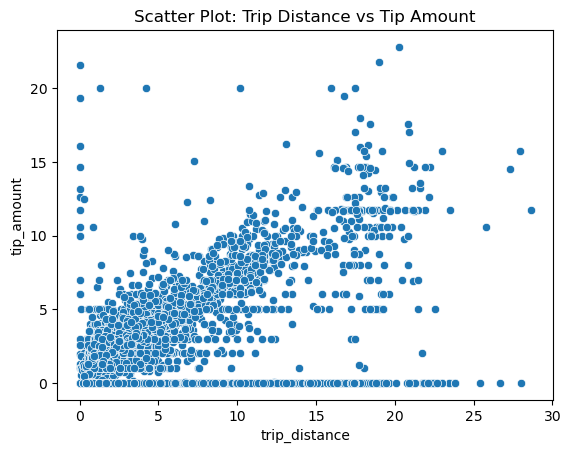

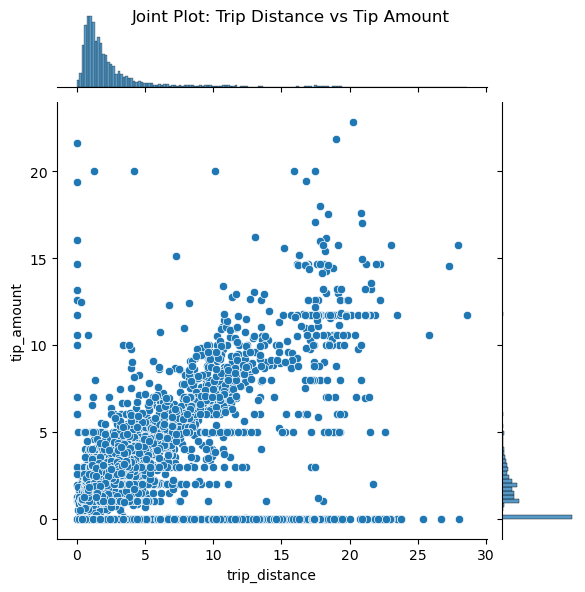

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Scatter plot
sns.scatterplot(x='trip_distance', y='tip_amount', data=trip_distance_tip_amount_df)
plt.title('Scatter Plot: Trip Distance vs Tip Amount')
plt.show()

# Joint plot
sns.jointplot(x='trip_distance', y='tip_amount', data=trip_distance_tip_amount_df, kind='scatter')
plt.suptitle('Joint Plot: Trip Distance vs Tip Amount')
plt.show()



# Instead of checking for a correlation using mathematical methods, we will plot the 2 variables and check for any patterns

# We see that there is indeed a correlation between the trip distance and the tip amount.
# As the trip distance increases, the tip amount also increases.